In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# importing the required modals

import joblib

# Load the saved models
temperature_model = joblib.load('./models/temperature_model.pkl')
humidity_model = joblib.load('./models/humidity_model.pkl')
wind_speed_model = joblib.load('./models/wind_speed_model.pkl')
power_model = joblib.load('./models/power_consumption.pkl')


In [3]:
# importing data
filePath = "./Data/cleaned_weather_data.csv"
weather_data = pd.read_csv(filePath)
weather_df = pd.DataFrame(weather_data)

In [4]:
weather_df.head()

,Datetime,Temperature (°C),Atmospheric Pressure (kPa),Precipitation mm/h,Solar Radiation (W/m2),Vapor Pressure (kPa),Humidity (%),Wind Direction (°),Wind Speed (m/s),Hour,Day,Month
0,2020-07-31 14:00:00+00:00,10.350000,101.491667,0.0,0.0,1.056667,84.183333,212.200000,0.331667,14,31,7
1,2020-07-31 15:00:00+00:00,10.783333,101.481667,0.0,0.0,1.095000,84.883333,257.433333,1.091667,15,31,7
2,2020-07-31 16:00:00+00:00,10.933333,101.463333,0.0,0.0,1.098333,83.966667,302.316667,1.023333,16,31,7
3,2020-07-31 17:00:00+00:00,10.033333,101.405000,0.0,0.0,1.076667,87.300000,269.500000,0.380000,17,31,7
4,2020-07-31 18:00:00+00:00,10.166667,101.378333,0.0,0.0,1.083333,87.133333,240.900000,0.515000,18,31,7


**If models perfom similary on a similar test set, that would confirm that models were imported properly**

Temperature

In [5]:
# create a new column with the target temperature for the next day.
weather_df['Target Temperature (°C)'] = weather_df['Temperature (°C)'].shift(-24)
#Drop rows with NaN values created by shifting
weather_df = weather_df.dropna()
# X is the feature matrix
X = weather_df.drop(columns=['Datetime', 'Temperature (°C)'])
# y is the target vector (the 'Target Temperature' column)
y = weather_df['Target Temperature (°C)']
# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [6]:
selected_features = [ 'Atmospheric Pressure (kPa)', 'Vapor Pressure (kPa)', 'Humidity (%)', 'Day', 'Hour', 'Wind Direction (°)', 'Month', 'Solar Radiation (W/m2)']


temp_pred = temperature_model.predict(X_test[selected_features])


# evaluation

from sklearn.metrics import mean_squared_error, r2_score

# Evaluate the model
mse = mean_squared_error(y_test, temp_pred)
r2 = r2_score(y_test, temp_pred)
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")
print(f'Mean Squared Error: {mse}')
print(f'R² Score: {r2}')

RMSE: 1.234760845790507
Mean Squared Error: 1.5246343462972884
R² Score: 0.920217203914653


# Predicting the weather conditions

Temperature

In [7]:
selected_features = [ 'Atmospheric Pressure (kPa)', 'Vapor Pressure (kPa)', 'Humidity (%)', 'Day', 'Hour', 'Wind Direction (°)', 'Month', 'Solar Radiation (W/m2)']
temp_pred = temperature_model.predict(weather_df[selected_features])

Humidity

In [8]:
selected_features = ['Temperature (°C)', 'Atmospheric Pressure (kPa)', 'Vapor Pressure (kPa)', 'Wind Speed (m/s)', 'Hour', 'Day', 'Month']
humidity_pred = humidity_model.predict(weather_df[selected_features])

Wind Speed

In [9]:
selected_features = ['Temperature (°C)', 'Atmospheric Pressure (kPa)', 'Solar Radiation (W/m2)', 'Vapor Pressure (kPa)', 'Humidity (%)', 'Wind Direction (°)', 'Wind Speed (m/s)', 'Hour', 'Day', 'Month']

# Create a polynomial feature matrix
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=2)
wind_poly = poly.fit_transform(weather_df[selected_features])
# Predict the wind speed
wind_speed_pred = wind_speed_model.predict(wind_poly)

In [10]:
# Combine the predicted temperature, humidity, and wind speed
power_model_input = np.column_stack((temp_pred, humidity_pred, wind_speed_pred, weather_df['Hour']))

In [11]:
# convert the power_model_input to a DataFrame
power_model_input_df = pd.DataFrame(power_model_input, columns=['Temperature', 'Humidity', 'WindSpeed', 'Hour'])

**Predicting power consumption of next day**

***Scaling***

In [12]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

# Initialize the scaler
scaler = RobustScaler()
#scaler = StandardScaler()
# scaler = MinMaxScaler()

# Normalize the features
og = power_model_input_df[['Temperature', 'Humidity', 'WindSpeed']]
power_model_input_df[['Temperature', 'Humidity', 'WindSpeed']] = scaler.fit_transform(power_model_input_df[['Temperature', 'Humidity', 'WindSpeed']])
power_model_input_df.head()

,Temperature,Humidity,WindSpeed,Hour
0,-1.397938,-0.077745,-0.291399,14.0
1,-1.443200,-0.069558,-0.439896,15.0
2,-1.547081,-0.007720,-0.336422,16.0
3,-1.652368,0.004165,-0.345635,17.0
4,-1.686814,0.010879,-0.206033,18.0


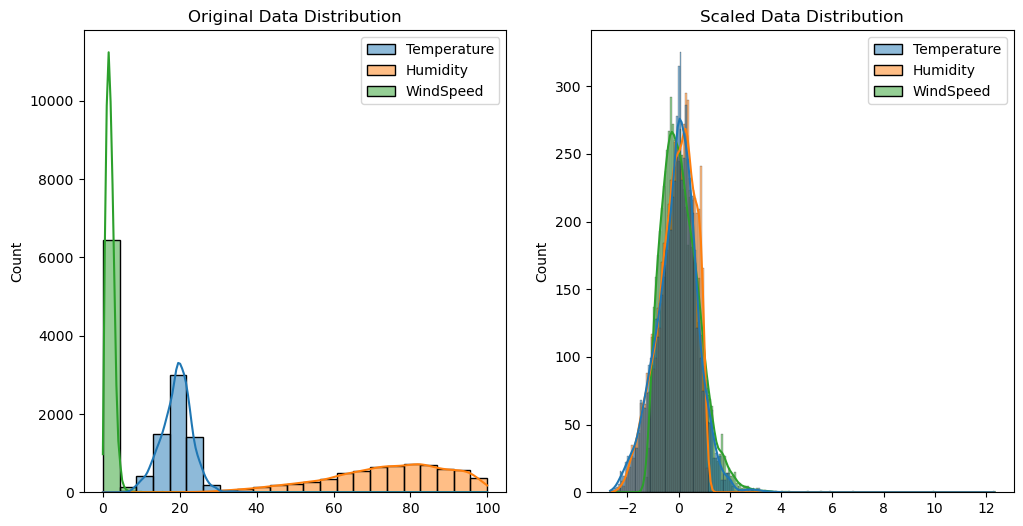

In [13]:
# Plot original data
plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
sns.histplot(og, kde=True)
plt.title('Original Data Distribution')

# After scaling
plt.subplot(1, 2, 2)
sns.histplot(power_model_input_df[['Temperature', 'Humidity', 'WindSpeed']], kde=True)
plt.title('Scaled Data Distribution')
plt.show()

In [14]:
selected_features = ['Temperature', 'Humidity', 'WindSpeed','Hour']
predicted_power_consumption = power_model.predict(power_model_input_df[selected_features])

Evaluation

In [15]:
# Add the predicted power consumption to the power_model_input
power_model_input_df['PowerClass'] = predicted_power_consumption


In [16]:
power_model_input_df.head()

,Temperature,Humidity,WindSpeed,Hour,PowerClass
0,-1.397938,-0.077745,-0.291399,14.0,Moderate
1,-1.443200,-0.069558,-0.439896,15.0,Moderate
2,-1.547081,-0.007720,-0.336422,16.0,Moderate
3,-1.652368,0.004165,-0.345635,17.0,Moderate
4,-1.686814,0.010879,-0.206033,18.0,High


In [17]:
power_model_input_df.describe()

,Temperature,Humidity,WindSpeed,Hour
count,6.574000e+03,6.574000e+03,6574.000000,6574.000000
mean,-6.078290e-02,-8.405292e-02,0.093984,11.511865
std,8.094328e-01,7.015381e-01,0.768441,6.923816
min,-2.670814e+00,-2.427008e+00,-1.263132,0.000000
25%,-5.557221e-01,-5.384110e-01,-0.454662,6.000000
50%,3.594808e-16,3.190807e-16,0.000000,12.000000
75%,4.442779e-01,4.615890e-01,0.545338,18.000000
max,3.824662e+00,1.080358e+00,12.329166,23.000000


In [18]:
power_model_input_df['PowerClass'].value_counts()

PowerClass
Moderate    2609
High        2258
Low         1707
Name: count, dtype: int64

The distribution of the classes show a reasonable prediction of the power consumption by the predicted weather conditions